 **Pro задание. 
Вариант 1**

Напишите PSPNet для сегментации на базе стройки, добейтесь максимально возможной
точности.

In [0]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dense # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [0]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Сегментация стройки

## Загрузка картинок

In [0]:
# Адаптация под базу находящуюся в zip архиве 

# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
num_classes = 7 # Задаем количество классов на изображении

# Импорт  и разархивирование музыкальных файлов
import zipfile
import io
z = zipfile.ZipFile('/content/drive/My Drive/Базы/Тестовое_стажировка_сегментация.zip', 'r')
z.extractall()

# Просмотр результата разорхивации
!ls Тестовое_стажировка_сегментация

# Параметры каталогов для обучающей и валидационных выборок
directory = 'Тестовое_стажировка_сегментация/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка' # Название папки с файлами проверочной выборки

# Просмотр первых 5 файлов в обучающей выборке
os.listdir(directory + train_directory+'/Исходники')[:5]

Контрольная_стройка  Проверочная_стройка  Тренировочная_стройка


['Img_718.jpg', 'Img_734.jpg', 'Img_382.jpg', 'Img_864.jpg', 'Img_816.jpg']

### Оригинальные изображения

In [0]:
train_images = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки
test_images = [] # Создаем пустой список для хранений оригинльных изображений тестовой выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути     
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images)) # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути                  
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images)) # Отображаем количество элементов в проверочной выборке

Обучающая выборка загржуена. Время загрузки: 11.23c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 0.59c
Количество изображений:  50


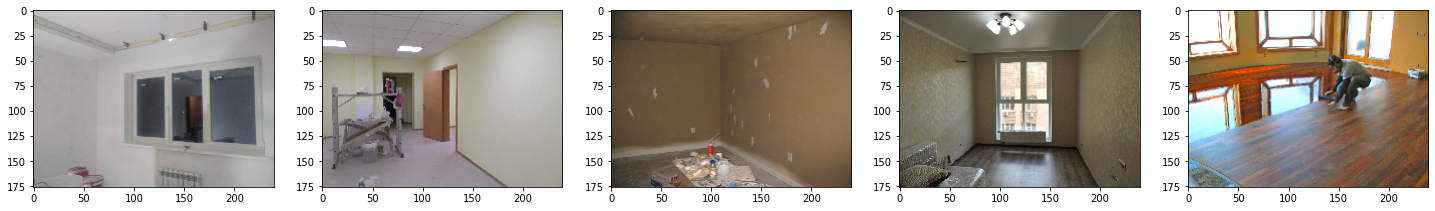

In [0]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_images) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

### Сегментированные изображения

In [0]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загржуена. Время загрузки: 2.33c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 0.13c
Количество изображений:  50


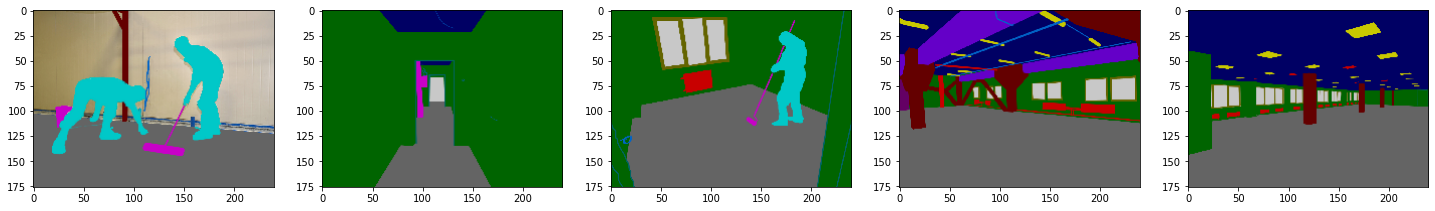

In [0]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_segments) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Создание выборки


In [0]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=0 # пол
  elif (49>=color[0]>=0)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=1 # потолок
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=2 # стена
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=4 # колонна
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=3 # проем
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=3 # дверь
  elif (149>=color[0]>=51)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=3 # окно
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=4 # внешний мир
  elif (49>=color[0]>=0)and(49>=color[1]>=51)and(249>=color[2]>=151) : index=4 # лестница
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4 # перила
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=4 # батарея
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=5 # люди
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=4 # инвентарь
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4 # источники света
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(249>=color[2]>=151) : index=4 # провода
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=4 # балка
  else: index=6
  return index  

In [0]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # потолок
  elif index == 2: color = [0, 100, 0]  # стена
  elif index == 3: color = [100, 0, 0]  # проем, дверь, окно
  elif index == 4: color = [0, 100, 100]  # колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
  elif index == 5: color = [100, 0, 100]  # люди
  elif index == 6: color = [0, 0, 0]  # остальное
  return color # Возвращаем цвет пикслея

In [0]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [0]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [0]:
# len_xTrain = 100
# len_xVal   = 20

len_xTrain = 900
len_xVal   = 50

xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images[: len_xTrain]: # Проходим по всем изображениям из train_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images[: len_xVal]: # Проходим по всем изображениям из val_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [0]:
# cur_time = time.time() # Засекаем текущее время
# yTrain = yt_prep(train_segments[: len_xTrain], num_classes)  # Создаем yTrain
# print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

In [0]:
# cur_time = time.time() # Засекаем текущее время
# yVal = yt_prep(val_segments[: len_xVal], num_classes) # Создаем yVal
# print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

In [0]:
yTrain = np.load('/content/drive/My Drive/Базы/building/building_yTrain.npy')
yVal   = np.load('/content/drive/My Drive/Базы/building/building_yVal.npy')

In [0]:
print('Тренировочная выборка')
print(xTrain.shape)
print(yTrain.shape)
print()

print('Валидационная выборка')
print(xVal.shape)
print(yVal.shape)

Тренировочная выборка
(900, 176, 240, 3)
(900, 176, 240, 7)

Валидационная выборка
(50, 176, 240, 3)
(50, 176, 240, 7)


In [0]:
# Функция вычисляющая веса классов
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [0]:
count_el_list = []

for cl in range(num_classes):
  count_el = 0
  for i in range(yTrain.shape[0]):
    y_arr = yTrain[i][:,:,cl]
    count_el += len(np.nonzero(y_arr)[0])
  count_el_list.append(count_el)

#print(count_el)
#print(yTrain[i][:,:,0].shape[0]*yTrain[i][:,:,0].shape[1])
print(count_el_list)

lab_dict = {}
for i in range(num_classes):
  lab_dict[i] = count_el_list[i]
print(lab_dict)

wd = create_class_weight(lab_dict, mu=0.15)

print(wd)
print(wd.values())


[7202780, 4697198, 19968903, 1259129, 4176294, 620203, 91493]
{0: 7202780, 1: 4697198, 2: 19968903, 3: 1259129, 4: 4176294, 5: 620203, 6: 91493}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.5104669267693442, 4: 1.0, 5: 2.218595574032479, 6: 4.132379951213683}
dict_values([1.0, 1.0, 1.0, 1.5104669267693442, 1.0, 2.218595574032479, 4.132379951213683])


In [0]:
# xTrain = xTrain/255
# xVal = xVal/255
# print(xTrain[0])

In [0]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 5)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

In [0]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [0]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def jaccard_coef(y_true, y_pred):
    return (K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred) - K.sum(y_true * y_pred)) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

## Модели

*Разбор данного раздела:* https://youtu.be/1cJcJY3K-Ow?t=2509

### Линейная сегментирующая сеть - 0.33



*Разбор данного раздела:* https://youtu.be/1cJcJY3K-Ow?t=2658

In [0]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def linearSegmentationNet(
      num_classes = 6,
      input_shape = (88, 120, 3)
      ):
    img_input = Input(input_shape)                                          # Создаем входной слой с размерностью input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

In [0]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # Создаем моель linearSegmentationNet
history = modelL.fit(xTrain, yTrain, epochs=20, batch_size=8, validation_data=(xVal, yVal)) # Обучаем модель на выборке по трем классам

Epoch 1/20
13/13 [==============================] - 3s 203ms/step - loss: 1.6402 - dice_coef: 0.3058 - val_loss: 6.5904 - val_dice_coef: 0.2396
Epoch 2/20
13/13 [==============================] - 2s 190ms/step - loss: 1.3308 - dice_coef: 0.3493 - val_loss: 3.8412 - val_dice_coef: 0.1912
Epoch 3/20
13/13 [==============================] - 3s 193ms/step - loss: 1.2997 - dice_coef: 0.3529 - val_loss: 4.8495 - val_dice_coef: 0.1175
Epoch 4/20
13/13 [==============================] - 3s 193ms/step - loss: 1.2898 - dice_coef: 0.3648 - val_loss: 4.7107 - val_dice_coef: 0.1164
Epoch 5/20
13/13 [==============================] - 2s 192ms/step - loss: 1.2732 - dice_coef: 0.3705 - val_loss: 1.9035 - val_dice_coef: 0.2156
Epoch 6/20
13/13 [==============================] - 2s 191ms/step - loss: 1.2837 - dice_coef: 0.3643 - val_loss: 3.4829 - val_dice_coef: 0.1333
Epoch 7/20
13/13 [==============================] - 3s 193ms/step - loss: 1.2399 - dice_coef: 0.3655 - val_loss: 2.9663 - val_dice_coef:

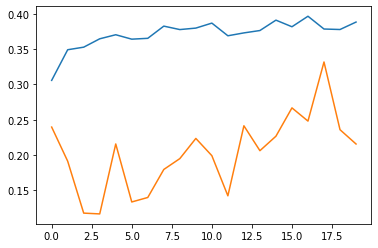

In [0]:
# Отобразим график обучения модели
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [0]:
#modelL.save_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelL.h5')

#### Распознавание

In [0]:
# modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # Создаем моель linearSegmentationNet
# modelL.load_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelL.h5')

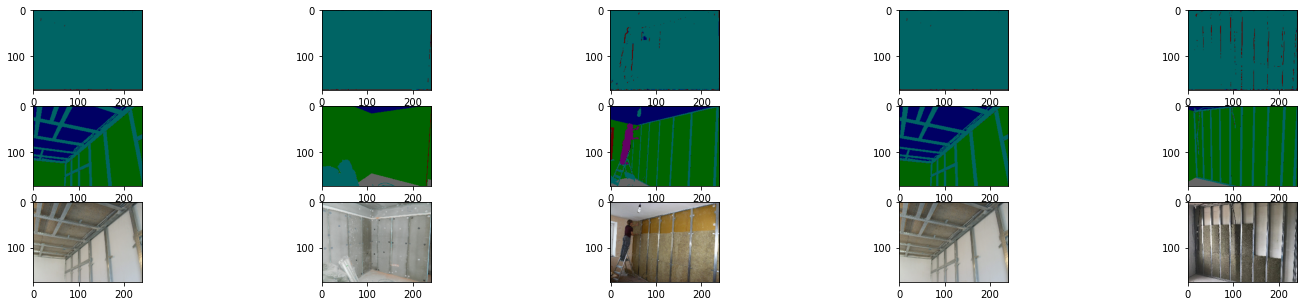

In [0]:
processImage(modelL, 5, num_classes)

bold text### U-net - 0.47

*Разбор данного раздела:* https://youtu.be/1cJcJY3K-Ow?t=3753

In [0]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [0]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet
history = modelUnet.fit(xTrain, yTrain, epochs=30, batch_size=8, validation_data = (xVal, yVal)) # Обучаем модель на выборке по трем классам

Epoch 1/30
13/13 [==============================] - 12s 890ms/step - loss: 1.6080 - dice_coef: 0.2918 - val_loss: 12.0874 - val_dice_coef: 0.2429
Epoch 2/30
13/13 [==============================] - 8s 590ms/step - loss: 1.3304 - dice_coef: 0.3561 - val_loss: 11.7820 - val_dice_coef: 0.2485
Epoch 3/30
13/13 [==============================] - 8s 592ms/step - loss: 1.2663 - dice_coef: 0.3564 - val_loss: 7.3156 - val_dice_coef: 0.1649
Epoch 4/30
13/13 [==============================] - 8s 592ms/step - loss: 1.2000 - dice_coef: 0.3988 - val_loss: 10.3921 - val_dice_coef: 0.1976
Epoch 5/30
13/13 [==============================] - 8s 594ms/step - loss: 1.0530 - dice_coef: 0.4611 - val_loss: 4.0797 - val_dice_coef: 0.1463
Epoch 6/30
13/13 [==============================] - 8s 595ms/step - loss: 0.9762 - dice_coef: 0.4852 - val_loss: 3.0906 - val_dice_coef: 0.1834
Epoch 7/30
13/13 [==============================] - 8s 595ms/step - loss: 0.9419 - dice_coef: 0.5163 - val_loss: 4.8177 - val_dice_c

In [0]:
#modelUnet.save_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelUnet.h5')

#### Распознавание

In [0]:
# modelUnet = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet
# modelUnet.load_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelUnet.h5')

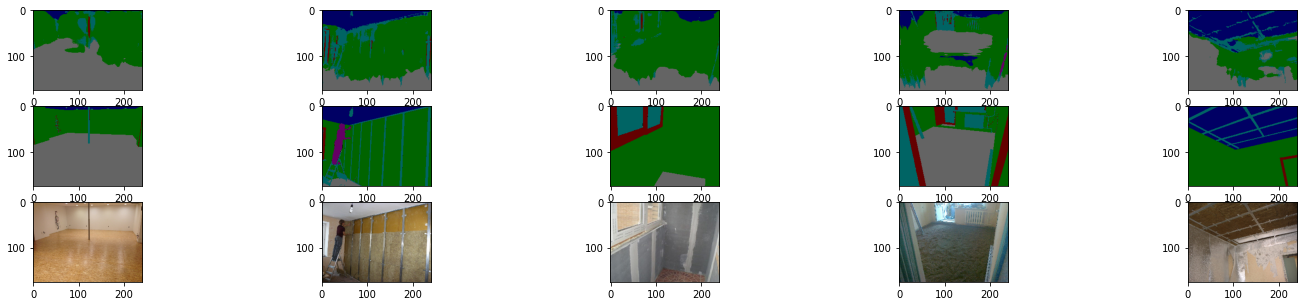

In [0]:
processImage(modelUnet, 5, num_classes)


### Упрощённая U-net - 0.47

*Разбор данного раздела:* https://youtu.be/1cJcJY3K-Ow?t=5089

In [0]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def simpleUnet(num_classes = 6, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D
    
    # UP 1
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(num_classes,(3,3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                            # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

In [0]:
modelS = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS.fit(xTrain, yTrain, epochs=30, batch_size=8, validation_data = (xVal, yVal)) # Обучаем модель на выборке по трем классам

Epoch 1/30
13/13 [==============================] - 3s 207ms/step - loss: 1.7955 - dice_coef: 0.2169 - val_loss: 2.1297 - val_dice_coef: 0.2099
Epoch 2/30
13/13 [==============================] - 2s 136ms/step - loss: 1.3976 - dice_coef: 0.3280 - val_loss: 3.1725 - val_dice_coef: 0.1675
Epoch 3/30
13/13 [==============================] - 2s 136ms/step - loss: 1.3192 - dice_coef: 0.3433 - val_loss: 2.6418 - val_dice_coef: 0.1169
Epoch 4/30
13/13 [==============================] - 2s 137ms/step - loss: 1.2895 - dice_coef: 0.3612 - val_loss: 2.3601 - val_dice_coef: 0.1461
Epoch 5/30
13/13 [==============================] - 2s 136ms/step - loss: 1.2618 - dice_coef: 0.3786 - val_loss: 1.7306 - val_dice_coef: 0.1843
Epoch 6/30
13/13 [==============================] - 2s 136ms/step - loss: 1.2311 - dice_coef: 0.3772 - val_loss: 1.7455 - val_dice_coef: 0.1874
Epoch 7/30
13/13 [==============================] - 2s 137ms/step - loss: 1.1897 - dice_coef: 0.4011 - val_loss: 1.6079 - val_dice_coef:

In [0]:
# modelS.save_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelS.h5')

#### Распознавание

In [0]:
# modelS = simpleUnet(num_classes, (img_width, img_height, 3))    
# modelS.load_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelS.h5')

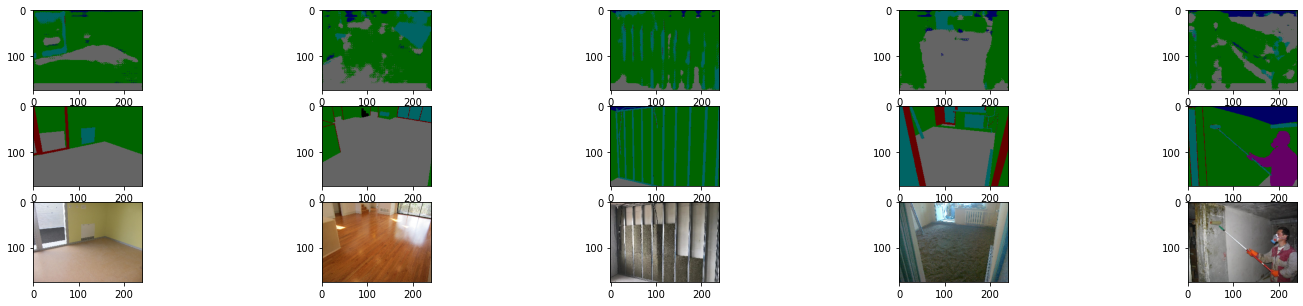

In [0]:
processImage(modelS, 5, num_classes)

### Расширенная U-net - 0.72

In [0]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask(num_classes = 6, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

In [0]:
modelM3 = unetWithMask(num_classes, (img_width, img_height,3))
history = modelM3.fit(xTrain, yTrain, epochs=60, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/60
57/57 [==============================] - 23s 396ms/step - loss: 1.2886 - dice_coef: 0.3869 - val_loss: 14.5352 - val_dice_coef: 0.0695
Epoch 2/60
57/57 [==============================] - 20s 352ms/step - loss: 0.9778 - dice_coef: 0.5025 - val_loss: 6.8550 - val_dice_coef: 0.4496
Epoch 3/60
57/57 [==============================] - 20s 352ms/step - loss: 0.8819 - dice_coef: 0.5561 - val_loss: 5.4896 - val_dice_coef: 0.4124
Epoch 4/60
57/57 [==============================] - 20s 352ms/step - loss: 0.8326 - dice_coef: 0.5823 - val_loss: 3.7360 - val_dice_coef: 0.3524
Epoch 5/60
57/57 [==============================] - 20s 352ms/step - loss: 0.8093 - dice_coef: 0.5949 - val_loss: 2.3325 - val_dice_coef: 0.5286
Epoch 6/60
57/57 [==============================] - 20s 352ms/step - loss: 0.7573 - dice_coef: 0.6213 - val_loss: 2.4373 - val_dice_coef: 0.4487
Epoch 7/60
57/57 [==============================] - 20s 352ms/step - loss: 0.7385 - dice_coef: 0.6291 - val_loss: 2.2793 - val_di

In [0]:
# modelM3.save_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelM3.h5')

#### Распознавание

In [0]:
# modelM3 = unetWithMask(num_classes, (img_width, img_height,3))
# modelM3.load_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelM3.h5')

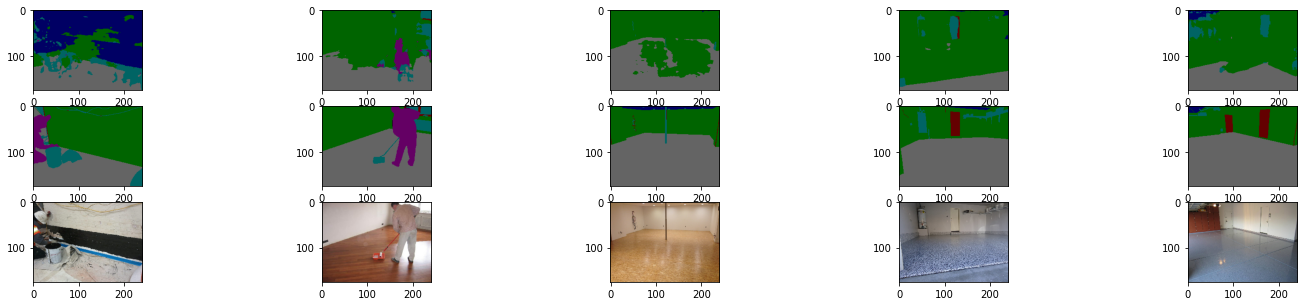

In [0]:
processImage(modelM3, 5, num_classes)

# PSP_net - 0.74

In [0]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPnet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Входной блок сверток
    x = Conv2D(64, (3, 3), padding='same', name='Input_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='Input_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation и запоминаем в переменной block_1_out

    # bl_2 - Блок сверток с размером MaxPulling = 2
    bl_2 = MaxPooling2D(pool_size=(2, 2))(x)                               # Добавляем слой MaxPooling2D
    
    bl_2 = Conv2D(128, (3, 3), padding='same', name='bl_2_conv1')(bl_2)    # Добавляем Conv2D-слой с 128-нейронами
    bl_2 = BatchNormalization()(bl_2)                                      # Добавляем слой BatchNormalization
    bl_2 = Activation('relu')(bl_2)                                        # Добавляем слой Activation

    bl_2 = Conv2D(128, (3, 3), padding='same', name='bl_2_conv2')(bl_2)    # Добавляем Conv2D-слой с 128-нейронами
    bl_2 = BatchNormalization()(bl_2)                                      # Добавляем слой BatchNormalization
    bl_2 = Activation('relu')(bl_2)                                        # Добавляем слой Activation и запоминаем в переменной block_2_out

    bl_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='bl_2_convTr')(bl_2)    # Добавляем слой Conv2DTranspose с 128 нейронами

    # bl_4 - Блок сверток с размером MaxPulling = 4
    bl_4 = MaxPooling2D(pool_size=(4, 4))(x)                               # Добавляем слой MaxPooling2D
    
    bl_4 = Conv2D(256, (3, 3), padding='same', name='bl_4_conv1')(bl_4)    # Добавляем Conv2D-слой с 128-нейронами
    bl_4 = BatchNormalization()(bl_4)                                      # Добавляем слой BatchNormalization
    bl_4 = Activation('relu')(bl_4)                                        # Добавляем слой Activation

    bl_4 = Conv2D(256, (3, 3), padding='same', name='bl_4_conv2')(bl_4)    # Добавляем Conv2D-слой с 128-нейронами
    bl_4 = BatchNormalization()(bl_4)                                      # Добавляем слой BatchNormalization
    bl_4 = Activation('relu')(bl_4)                                        # Добавляем слой Activation и запоминаем в переменной block_2_out

    bl_4 = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='bl_4_convTr')(bl_4)    # Добавляем слой Conv2DTranspose с 128 нейронами

    # bl_8 - Блок сверток с размером MaxPulling = 8
    bl_8 = MaxPooling2D(pool_size=(8, 8))(x)                               # Добавляем слой MaxPooling2D
    
    bl_8 = Conv2D(512, (3, 3), padding='same', name='bl_8_conv1')(bl_8)    # Добавляем Conv2D-слой с 128-нейронами
    bl_8 = BatchNormalization()(bl_8)                                      # Добавляем слой BatchNormalization
    bl_8 = Activation('relu')(bl_8)                                        # Добавляем слой Activation

    bl_8 = Conv2D(512, (3, 3), padding='same', name='bl_8_conv2')(bl_8)    # Добавляем Conv2D-слой с 128-нейронами
    bl_8 = BatchNormalization()(bl_8)                                      # Добавляем слой BatchNormalization
    bl_8 = Activation('relu')(bl_8)                                        # Добавляем слой Activation и запоминаем в переменной block_2_out

    bl_8 = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='bl_8_convTr')(bl_8)    # Добавляем слой Conv2DTranspose с 128 нейронами

    # bl_16 - Блок сверток с размером MaxPulling = 16
    bl_16 = MaxPooling2D(pool_size=(16, 16))(x)                              # Добавляем слой MaxPooling2D
    
    bl_16 = Conv2D(1024, (3, 3), padding='same', name='bl_16_conv1')(bl_16)  # Добавляем Conv2D-слой с 128-нейронами
    bl_16 = BatchNormalization()(bl_16)                                      # Добавляем слой BatchNormalization
    bl_16 = Activation('relu')(bl_16)                                        # Добавляем слой Activation

    bl_16 = Conv2D(1024, (3, 3), padding='same', name='bl_16_conv2')(bl_16)  # Добавляем Conv2D-слой с 128-нейронами
    bl_16 = BatchNormalization()(bl_16)                                      # Добавляем слой BatchNormalization
    bl_16 = Activation('relu')(bl_16)                                        # Добавляем слой Activation и запоминаем в переменной block_2_out

    bl_16 = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='bl_16_convTr')(bl_16)    # Добавляем слой Conv2DTranspose с 128 нейронами
    


    # Выходной блок
    out = concatenate([x, bl_2, bl_4, bl_8, bl_16]) 

    out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out) # Добавляем слой Conv2D с 64 нейронами
    out = BatchNormalization()(out) # Добавляем слой BatchNormalization
    out = Activation('relu')(out) # Добавляем слой Activation

    out = Conv2D(64, (3, 3), padding='same', name='out_conv2')(out) # Добавляем слой Conv2D с 64 нейронами
    out = BatchNormalization()(out) # Добавляем слой BatchNormalization
    out = Activation('relu')(out) # Добавляем слой Activation

    out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, out) # Создаем модель с входом 'img_input' и выходом 'out'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    #model.summary()
    return model # Возвращаем сформированную модель
    

In [0]:
model_PSPnet = PSPnet(num_classes, (img_width, img_height,3))
model_PSPnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
Input_conv1 (Conv2D)            (None, 176, 240, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 176, 240, 64) 256         Input_conv1[0][0]                
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 176, 240, 64) 0           batch_normalization_25[0][0]     
____________________________________________________________________________________________

In [0]:
model_PSPnet = PSPnet(num_classes, (img_width, img_height,3))
history = model_PSPnet.fit(xTrain, yTrain, epochs=60, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/60
57/57 [==============================] - 19s 325ms/step - loss: 1.0371 - dice_coef: 0.5008 - val_loss: 6.0855 - val_dice_coef: 0.2187
Epoch 2/60
57/57 [==============================] - 18s 309ms/step - loss: 0.8468 - dice_coef: 0.5720 - val_loss: 2.4376 - val_dice_coef: 0.2695
Epoch 3/60
57/57 [==============================] - 18s 309ms/step - loss: 0.7984 - dice_coef: 0.5949 - val_loss: 1.2937 - val_dice_coef: 0.4672
Epoch 4/60
57/57 [==============================] - 18s 310ms/step - loss: 0.7867 - dice_coef: 0.5978 - val_loss: 1.5589 - val_dice_coef: 0.4189
Epoch 5/60
57/57 [==============================] - 18s 309ms/step - loss: 0.7384 - dice_coef: 0.6244 - val_loss: 1.0760 - val_dice_coef: 0.5732
Epoch 6/60
57/57 [==============================] - 18s 309ms/step - loss: 0.7062 - dice_coef: 0.6366 - val_loss: 1.2433 - val_dice_coef: 0.5431
Epoch 7/60
57/57 [==============================] - 18s 309ms/step - loss: 0.6839 - dice_coef: 0.6469 - val_loss: 1.1401 - val_dic

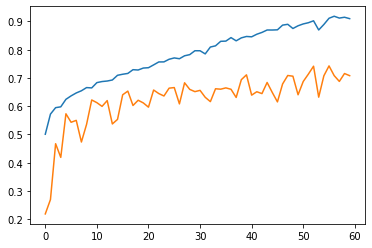

In [0]:
# Отобразим график обучения модели
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [0]:
# Запись натренированной модели
# model_PSPnet.save_weights('/content/drive/My Drive/UAI/Neuron Networks/Занятие №14 Сегментация/model_PSPnet.h5')

In [0]:
# Загрузка натренированной модели
# model_PSPnet = PSPnet(num_classes, (img_width, img_height,3))
# model_PSPnet.load_weights('/content/drive/My Drive/UAI/Neuron Networks/Занятие №14 Сегментация/model_PSPnet.h5')

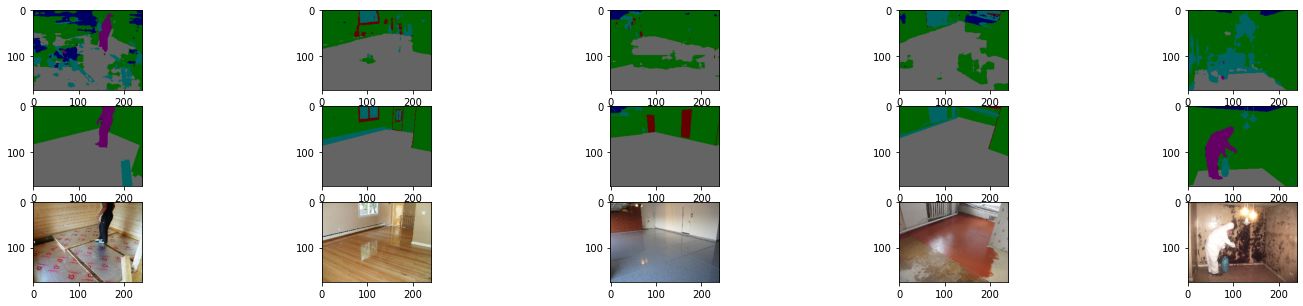

In [0]:
# Распознавание
processImage(model_PSPnet, 5, num_classes)

# Предтренированая классическая U net - 0.72

In [0]:
# Архитектура ближе U-net

# Увеличенный выходной слой
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 16 раз
out_mp_16x = mp_16x.output # 11*15*512
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_mp_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
out_x_con = concatenate([out_x, out_mp_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

# Компилируем модель 
model_U.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_U.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 176, 240, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 176, 240, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 88, 120, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
history = model_U.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 52s 57ms/step - loss: 1.3428 - dice_coef: 0.3682 - val_loss: 3.9816 - val_dice_coef: 0.0894
Epoch 2/10
900/900 [==============================] - 42s 47ms/step - loss: 1.1477 - dice_coef: 0.4287 - val_loss: 7.6285 - val_dice_coef: 0.1310
Epoch 3/10
900/900 [==============================] - 42s 47ms/step - loss: 0.9855 - dice_coef: 0.5151 - val_loss: 12.5141 - val_dice_coef: 0.1005
Epoch 4/10
900/900 [==============================] - 42s 47ms/step - loss: 0.8312 - dice_coef: 0.5941 - val_loss: 4.0969 - val_dice_coef: 0.4037
Epoch 5/10
900/900 [==============================] - 42s 47ms/step - loss: 0.7145 - dice_coef: 0.6550 - val_loss: 2.0366 - val_dice_coef: 0.5317
Epoch 6/10
900/900 [==============================] - 42s 47ms/step - loss: 0.6512 - dice_coef: 0.6840 - val_loss: 2.5581 - val_dice_coef: 0.4999
Epoch 7/10
900/900 [==============================] - 42s 47ms/step - loss: 0.

In [0]:
history = model_U.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 42s 47ms/step - loss: 0.5280 - dice_coef: 0.7442 - val_loss: 1.3839 - val_dice_coef: 0.6566
Epoch 2/10
900/900 [==============================] - 42s 47ms/step - loss: 0.5090 - dice_coef: 0.7518 - val_loss: 1.0392 - val_dice_coef: 0.6785
Epoch 3/10
900/900 [==============================] - 42s 47ms/step - loss: 0.4959 - dice_coef: 0.7559 - val_loss: 1.1420 - val_dice_coef: 0.7185
Epoch 4/10
900/900 [==============================] - 42s 47ms/step - loss: 0.4832 - dice_coef: 0.7644 - val_loss: 0.9629 - val_dice_coef: 0.6701
Epoch 5/10
900/900 [==============================] - 42s 47ms/step - loss: 0.4704 - dice_coef: 0.7698 - val_loss: 0.8457 - val_dice_coef: 0.7044
Epoch 6/10
900/900 [==============================] - 42s 47ms/step - loss: 0.4540 - dice_coef: 0.7750 - val_loss: 1.0611 - val_dice_coef: 0.6470
Epoch 7/10
900/900 [==============================] - 42s 47ms/step - loss: 0.4

# U_net + FPN - 0.7485

In [0]:
# Архитектура ближе U-net

# Увеличенный выходной слой
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 16 раз
out_mp_16x = mp_16x.output # 11*15*512
out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_mp_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_mp_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

# Компилируем модель 
model_U_Fpn.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_U_Fpn.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 176, 240, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 176, 240, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 88, 120, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
history = model_U_Fpn.fit(xTrain, yTrain, epochs=20, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/20
900/900 [==============================] - 72s 80ms/step - loss: 0.8798 - dice_coef: 0.5841 - val_loss: 3.3771 - val_dice_coef: 0.4434
Epoch 2/20
900/900 [==============================] - 70s 78ms/step - loss: 0.5593 - dice_coef: 0.7116 - val_loss: 1.0538 - val_dice_coef: 0.6395
Epoch 3/20
900/900 [==============================] - 70s 78ms/step - loss: 0.5139 - dice_coef: 0.7383 - val_loss: 0.8508 - val_dice_coef: 0.5933
Epoch 4/20
900/900 [==============================] - 70s 78ms/step - loss: 0.4753 - dice_coef: 0.7558 - val_loss: 0.6573 - val_dice_coef: 0.7186
Epoch 5/20
900/900 [==============================] - 70s 78ms/step - loss: 0.4452 - dice_coef: 0.7717 - val_loss: 0.6758 - val_dice_coef: 0.7428
Epoch 6/20
900/900 [==============================] - 70s 77ms/step - loss: 0.4178 - dice_coef: 0.7839 - val_loss: 0.7311 - val_dice_coef: 0.7216
Epoch 7/20
900/900 [==============================] - 70s 78ms/step - loss: 0.4

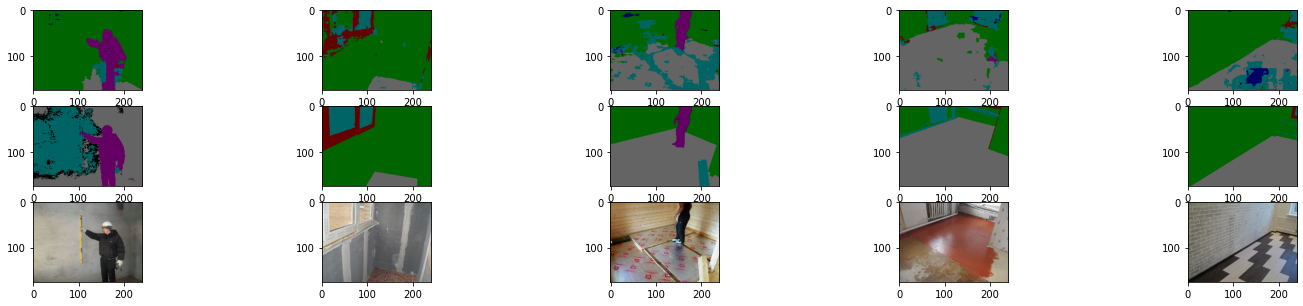

In [0]:
# Распознавание
processImage(model_U_Fpn, 5, num_classes)

# U-net с глубиной сжатия - 32 - 0.76

---



In [0]:
# Углубление сети до 32 степени сжатия
# Архитектура U-net

# Увеличенный выходной слой
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_32x_5')(out_32x)
#######################################################################################################

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
out_x_con = concatenate([out_x, out_mp_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

# Компилируем модель 
model_U.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_U.summary()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 176, 240, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_15[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 176, 240, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 88, 120, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
history = model_U.fit(xTrain, yTrain, epochs=10, batch_size=8, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 58s 64ms/step - loss: 0.4866 - dice_coef: 0.7694 - val_loss: 1.0506 - val_dice_coef: 0.7671
Epoch 2/10
900/900 [==============================] - 56s 62ms/step - loss: 0.4638 - dice_coef: 0.7766 - val_loss: 0.8221 - val_dice_coef: 0.7532
Epoch 3/10
900/900 [==============================] - 56s 62ms/step - loss: 0.4373 - dice_coef: 0.7858 - val_loss: 1.1428 - val_dice_coef: 0.6986
Epoch 4/10
900/900 [==============================] - 56s 62ms/step - loss: 0.4074 - dice_coef: 0.7990 - val_loss: 0.9279 - val_dice_coef: 0.7409
Epoch 5/10
900/900 [==============================] - 56s 62ms/step - loss: 0.3909 - dice_coef: 0.8056 - val_loss: 0.8500 - val_dice_coef: 0.7358
Epoch 6/10
900/900 [==============================] - 56s 62ms/step - loss: 0.3916 - dice_coef: 0.8051 - val_loss: 0.8788 - val_dice_coef: 0.7597
Epoch 7/10
900/900 [==============================] - 56s 62ms/step - loss: 0.3

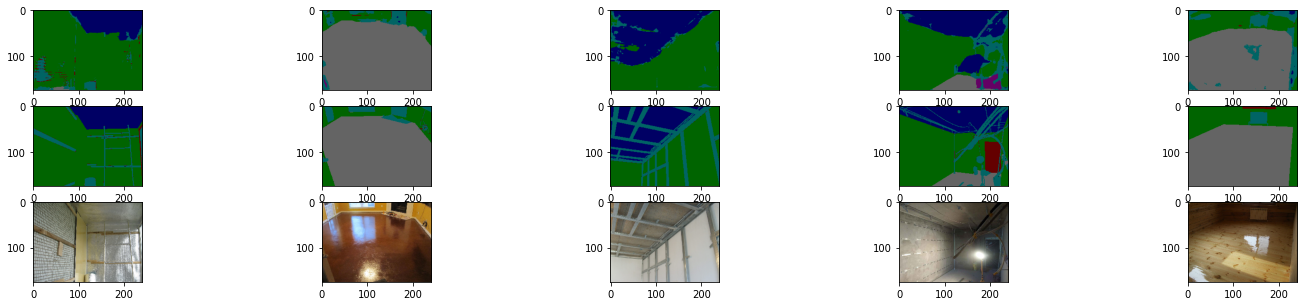

In [0]:
processImage(model_U, 5, num_classes)

# U_net + FPN Глубиной сжатия - 32 - 0.78

In [0]:
# U-net + FPN c с глубиной свертки до 32

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x_x   = Conv2DTranspose(8, (40, 42), strides=(34, 33),  name='conv2Dtr_32x_x')(out_mp_32x) # 176*240*64
###################################################################################################################

out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
out_x_con = concatenate([out_32x_x, out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_U_Fpn_32.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 176, 240, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 176, 240, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 88, 120, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=10, batch_size=8, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 105s 116ms/step - loss: 0.8435 - dice_coef: 0.6007 - val_loss: 1.0679 - val_dice_coef: 0.6557
Epoch 2/10
900/900 [==============================] - 98s 109ms/step - loss: 0.5636 - dice_coef: 0.7176 - val_loss: 0.7413 - val_dice_coef: 0.7360
Epoch 3/10
900/900 [==============================] - 98s 109ms/step - loss: 0.4902 - dice_coef: 0.7509 - val_loss: 0.7445 - val_dice_coef: 0.7117
Epoch 4/10
900/900 [==============================] - 98s 109ms/step - loss: 0.4475 - dice_coef: 0.7731 - val_loss: 0.6117 - val_dice_coef: 0.7465
Epoch 5/10
900/900 [==============================] - 98s 108ms/step - loss: 0.4020 - dice_coef: 0.7937 - val_loss: 0.6018 - val_dice_coef: 0.7574
Epoch 6/10
900/900 [==============================] - 98s 109ms/step - loss: 0.3783 - dice_coef: 0.8064 - val_loss: 1.0323 - val_dice_coef: 0.7096
Epoch 7/10
900/900 [==============================] - 98s 109ms/step - l

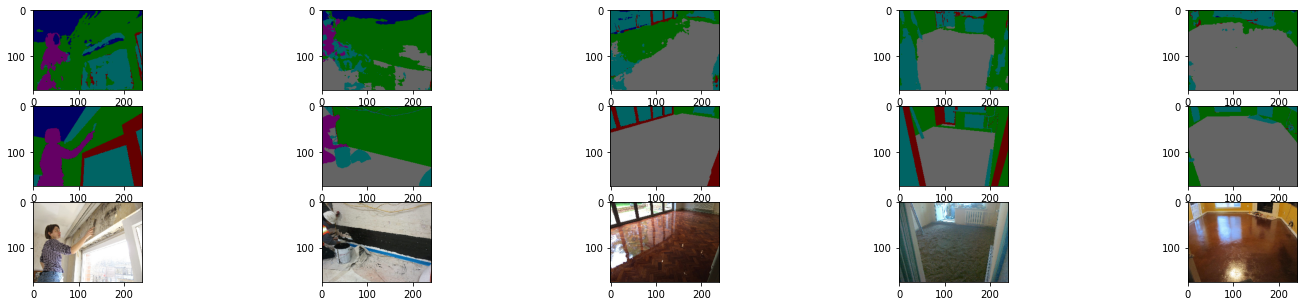

In [0]:
processImage(model_U_Fpn_32, 5, num_classes)

### Та же U_net + FPN но метрика jaccard

In [0]:
# Create a new model
model_U_Fpn_32j = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

# Компилируем модель 
model_U_Fpn_32j.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[jaccard_coef])
#model_U_Fpn_32j.summary()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  


In [0]:
history = model_U_Fpn_32j.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 85s 94ms/step - loss: 0.2138 - jaccard_coef: 0.7991 - val_loss: 0.7714 - val_jaccard_coef: 0.6616
Epoch 2/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1954 - jaccard_coef: 0.8130 - val_loss: 0.7584 - val_jaccard_coef: 0.6671
Epoch 3/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1835 - jaccard_coef: 0.8220 - val_loss: 0.8531 - val_jaccard_coef: 0.6601
Epoch 4/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1921 - jaccard_coef: 0.8170 - val_loss: 0.7974 - val_jaccard_coef: 0.6824
Epoch 5/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1694 - jaccard_coef: 0.8349 - val_loss: 0.8490 - val_jaccard_coef: 0.6173
Epoch 6/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1550 - jaccard_coef: 0.8475 - val_loss: 0.9380 - val_jaccard_coef: 0.6509
Epoch 7/10
900/900 [=======================

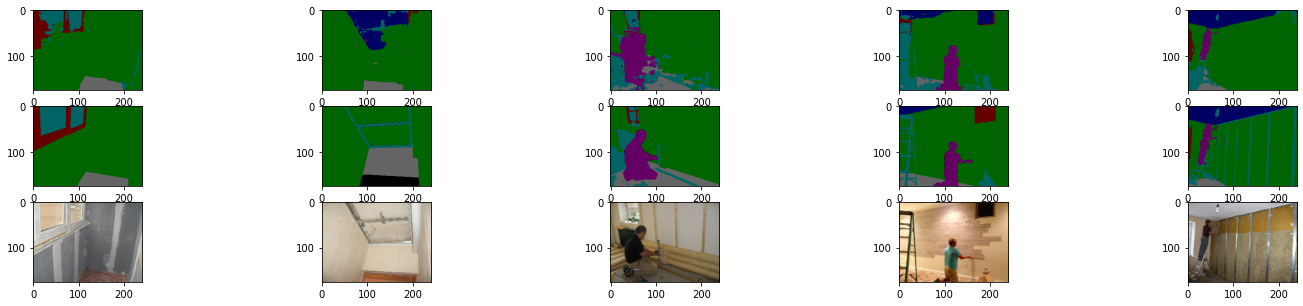

In [0]:
processImage(model_U_Fpn_32j, 5, num_classes)

In [0]:
# Заменяем дайс на жакарт и смотрим сколько получили на валидации.
# Компилируем модель 
model_U_Fpn_32j.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32j.fit(xTrain, yTrain, epochs=1, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/1
900/900 [==============================] - 84s 94ms/step - loss: 0.1302 - dice_coef: 0.9309 - val_loss: 1.0663 - val_dice_coef: 0.7773


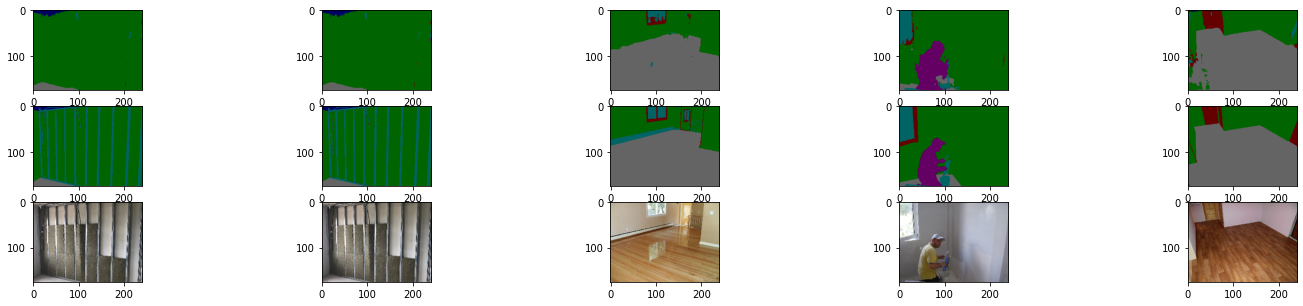

In [0]:
processImage(model_U_Fpn_32j, 5, num_classes)

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Компилируем модель 
model_U_Fpn_32j.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[jaccard_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32j.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 84s 94ms/step - loss: 0.1233 - jaccard_coef: 0.8771 - val_loss: 1.0214 - val_jaccard_coef: 0.6274
Epoch 2/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1157 - jaccard_coef: 0.8849 - val_loss: 1.0221 - val_jaccard_coef: 0.6196
Epoch 3/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1113 - jaccard_coef: 0.8876 - val_loss: 0.9684 - val_jaccard_coef: 0.6667
Epoch 4/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1084 - jaccard_coef: 0.8909 - val_loss: 1.0496 - val_jaccard_coef: 0.6810
Epoch 5/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1035 - jaccard_coef: 0.8954 - val_loss: 0.9936 - val_jaccard_coef: 0.6336
Epoch 6/10
900/900 [==============================] - 81s 90ms/step - loss: 0.1004 - jaccard_coef: 0.8975 - val_loss: 1.0413 - val_jaccard_coef: 0.6686
Epoch 7/10
900/900 [=======================

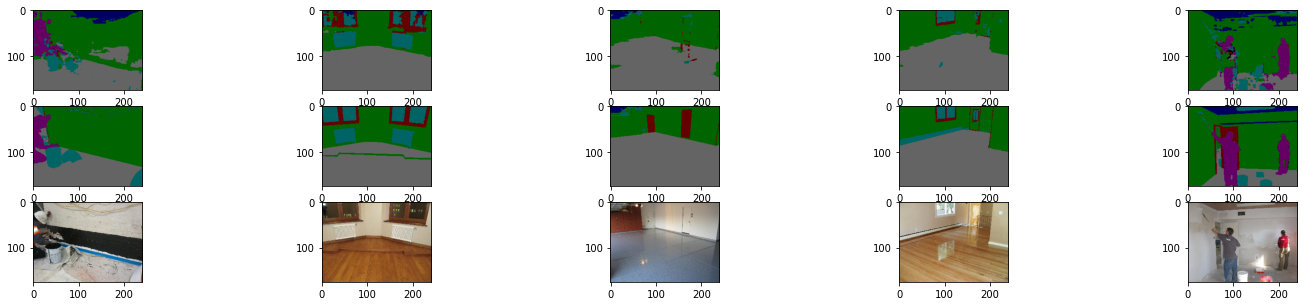

In [0]:
# Визуализация
processImage(model_U_Fpn_32j, 5, num_classes)

In [0]:
# Еще 10 эпох
history = model_U_Fpn_32j.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 82s 91ms/step - loss: 0.0976 - jaccard_coef: 0.9000 - val_loss: 1.0246 - val_jaccard_coef: 0.6665
Epoch 2/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0899 - jaccard_coef: 0.9085 - val_loss: 1.0716 - val_jaccard_coef: 0.6678
Epoch 3/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0847 - jaccard_coef: 0.9128 - val_loss: 1.0270 - val_jaccard_coef: 0.6739
Epoch 4/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0820 - jaccard_coef: 0.9157 - val_loss: 1.1180 - val_jaccard_coef: 0.6838
Epoch 5/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0774 - jaccard_coef: 0.9203 - val_loss: 1.1023 - val_jaccard_coef: 0.6690
Epoch 6/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0746 - jaccard_coef: 0.9219 - val_loss: 1.1162 - val_jaccard_coef: 0.6609
Epoch 7/10
900/900 [=======================

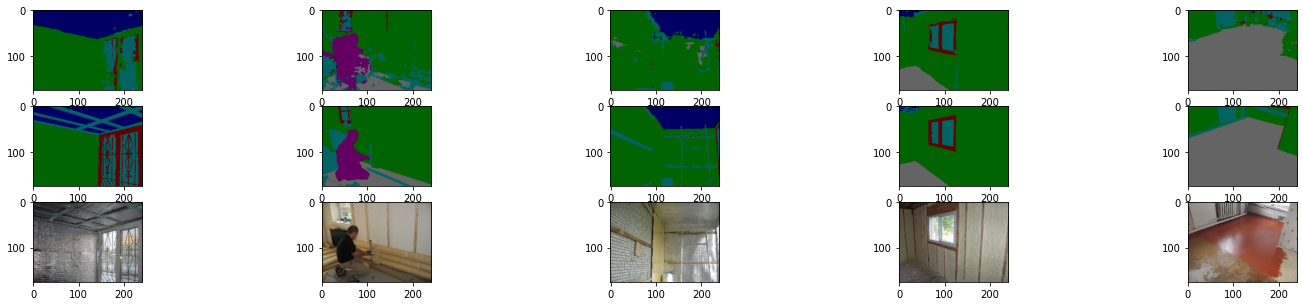

In [0]:
# Визуализация
processImage(model_U_Fpn_32j, 5, num_classes)

In [0]:
# Еще 10 эпох
history = model_U_Fpn_32j.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0734 - jaccard_coef: 0.9237 - val_loss: 1.0804 - val_jaccard_coef: 0.6742
Epoch 2/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0701 - jaccard_coef: 0.9269 - val_loss: 1.1245 - val_jaccard_coef: 0.6663
Epoch 3/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0664 - jaccard_coef: 0.9303 - val_loss: 1.1382 - val_jaccard_coef: 0.6665
Epoch 4/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0665 - jaccard_coef: 0.9302 - val_loss: 1.1355 - val_jaccard_coef: 0.6621
Epoch 5/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0654 - jaccard_coef: 0.9312 - val_loss: 1.1701 - val_jaccard_coef: 0.6613
Epoch 6/10
900/900 [==============================] - 81s 90ms/step - loss: 0.0638 - jaccard_coef: 0.9328 - val_loss: 1.1650 - val_jaccard_coef: 0.6867
Epoch 7/10
900/900 [=======================

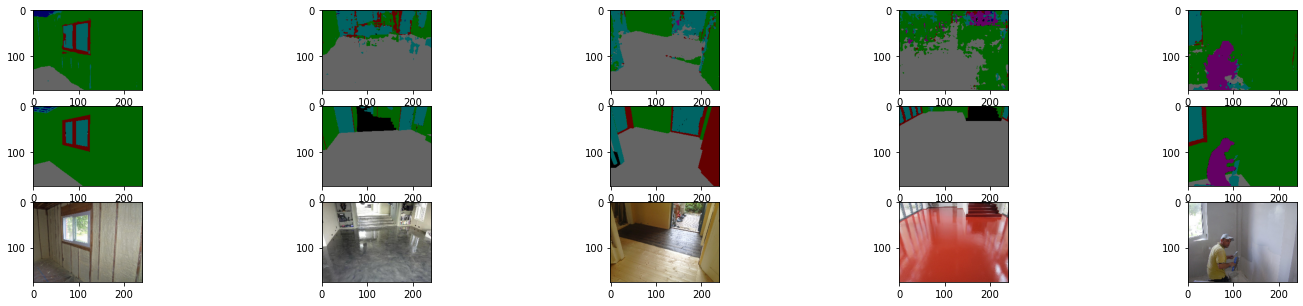

In [0]:
# Визуализация
processImage(model_U_Fpn_32j, 5, num_classes)

In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=30, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/30
900/900 [==============================] - 31s 35ms/step - loss: 0.7957 - dice_coef: 0.6153 - val_loss: 12.8890 - val_dice_coef: 0.1034
Epoch 2/30
900/900 [==============================] - 19s 21ms/step - loss: 0.6041 - dice_coef: 0.6915 - val_loss: 2.4970 - val_dice_coef: 0.3951
Epoch 3/30
900/900 [==============================] - 19s 21ms/step - loss: 0.5405 - dice_coef: 0.7228 - val_loss: 1.2750 - val_dice_coef: 0.5034
Epoch 4/30
900/900 [==============================] - 19s 21ms/step - loss: 0.4747 - dice_coef: 0.7564 - val_loss: 0.8222 - val_dice_coef: 0.6418
Epoch 5/30
900/900 [==============================] - 19s 21ms/step - loss: 0.4456 - dice_coef: 0.7690 - val_loss: 0.8035 - val_dice_coef: 0.7055
Epoch 6/30
900/900 [==============================] - 19s 21ms/step - loss: 0.4316 - dice_coef: 0.7783 - val_loss: 0.7943 - val_dice_coef: 0.7414
Epoch 7/30
900/900 [==============================] - 19s 21ms/step - loss: 0.

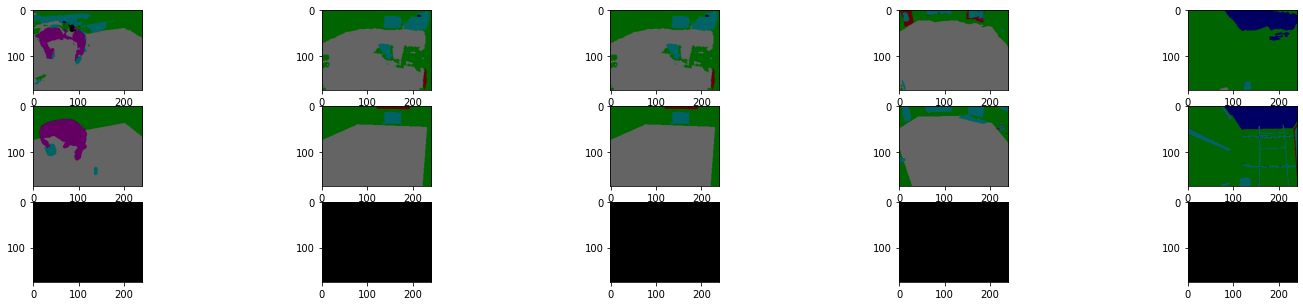

In [0]:

# Визуализация
processImage(model_U_Fpn_32, 5, num_classes)

# Добавляем дропаут на выходы FPN - 0.8185

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(256, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 69s 77ms/step - loss: 0.9377 - dice_coef: 0.5883 - val_loss: 3.3708 - val_dice_coef: 0.6088
Epoch 2/50
900/900 [==============================] - 62s 69ms/step - loss: 0.5552 - dice_coef: 0.7257 - val_loss: 1.2110 - val_dice_coef: 0.6658
Epoch 3/50
900/900 [==============================] - 62s 69ms/step - loss: 0.5020 - dice_coef: 0.7498 - val_loss: 1.0182 - val_dice_coef: 0.7149
Epoch 4/50
900/900 [==============================] - 62s 69ms/step - loss: 0.4505 - dice_coef: 0.7713 - val_loss: 0.7749 - val_dice_coef: 0.6738
Epoch 5/50
900/900 [==============================] - 62s 69ms/step - loss: 0.4230 - dice_coef: 0.7847 - val_loss: 0.7246 - val_dice_coef: 0.7372
Epoch 6/50
900/900 [==============================] - 62s 69ms/step - loss: 0.3689 - dice_coef: 0.8058 - val_loss: 0.8365 - val_dice_coef: 0.7575
Epoch 7/50
900/900 [==============================] - 62s 69ms/step - loss: 0.3

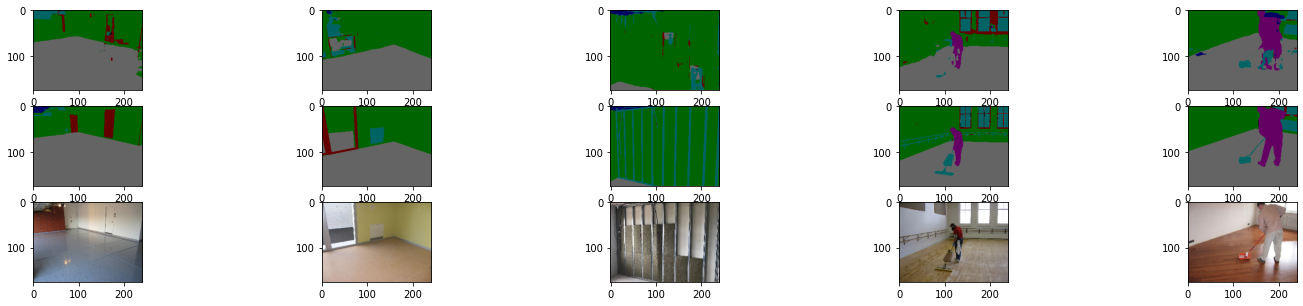

In [0]:

# Визуализация
processImage(model_U_Fpn_32, 5, num_classes)

# Добавляем дропаут на выходы FPN - 0.825 последний слой 5*5

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (5, 5), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_5_5 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32_5_5.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32_5_5.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 24s 27ms/step - loss: 0.9831 - dice_coef: 0.5522 - val_loss: 4.6390 - val_dice_coef: 0.4667
Epoch 2/50
900/900 [==============================] - 21s 23ms/step - loss: 0.5866 - dice_coef: 0.7131 - val_loss: 1.7182 - val_dice_coef: 0.6629
Epoch 3/50
900/900 [==============================] - 21s 23ms/step - loss: 0.5152 - dice_coef: 0.7407 - val_loss: 0.8931 - val_dice_coef: 0.7260
Epoch 4/50
900/900 [==============================] - 21s 23ms/step - loss: 0.4589 - dice_coef: 0.7667 - val_loss: 0.7319 - val_dice_coef: 0.7308
Epoch 5/50
900/900 [==============================] - 21s 23ms/step - loss: 0.4278 - dice_coef: 0.7797 - val_loss: 0.7655 - val_dice_coef: 0.7523
Epoch 6/50
900/900 [==============================] - 21s 23ms/step - loss: 0.3880 - dice_coef: 0.7997 - val_loss: 0.7471 - val_dice_coef: 0.7832
Epoch 7/50
900/900 [==============================] - 21s 23ms/step - loss: 0.3

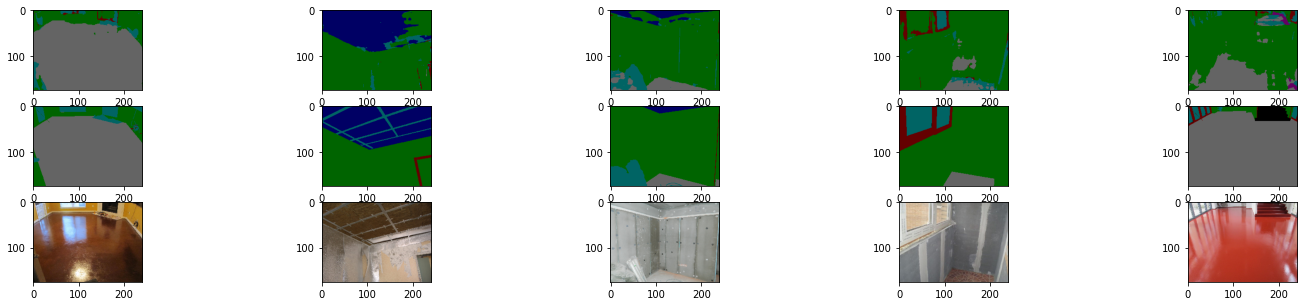

In [0]:
# Визуализация
processImage(model_U_Fpn_32_5_5, 5, num_classes)

# Добавляем дропаут на выходы FPN - 0.821 последний слой 1*1

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (1, 1), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_1_1 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32_1_1.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32_1_1.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 23s 26ms/step - loss: 1.1442 - dice_coef: 0.4756 - val_loss: 5.9684 - val_dice_coef: 0.4494
Epoch 2/50
900/900 [==============================] - 20s 23ms/step - loss: 0.6079 - dice_coef: 0.6932 - val_loss: 1.4812 - val_dice_coef: 0.5138
Epoch 3/50
900/900 [==============================] - 20s 23ms/step - loss: 0.5108 - dice_coef: 0.7350 - val_loss: 0.6750 - val_dice_coef: 0.7552
Epoch 4/50
900/900 [==============================] - 20s 23ms/step - loss: 0.4481 - dice_coef: 0.7637 - val_loss: 0.6537 - val_dice_coef: 0.7352
Epoch 5/50
900/900 [==============================] - 20s 23ms/step - loss: 0.4106 - dice_coef: 0.7820 - val_loss: 0.6958 - val_dice_coef: 0.7418
Epoch 6/50
900/900 [==============================] - 20s 23ms/step - loss: 0.3826 - dice_coef: 0.7986 - val_loss: 0.7130 - val_dice_coef: 0.7826
Epoch 7/50
900/900 [==============================] - 20s 23ms/step - loss: 0.3

In [0]:
# Визуализация
processImage(model_U_Fpn_32_1_1, 5, num_classes)

# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16 - 0.8229

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (1, 1), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 23s 26ms/step - loss: 1.1746 - dice_coef: 0.4607 - val_loss: 4.4811 - val_dice_coef: 0.5005
Epoch 2/50
900/900 [==============================] - 20s 23ms/step - loss: 0.5977 - dice_coef: 0.6958 - val_loss: 1.3120 - val_dice_coef: 0.5988
Epoch 3/50
900/900 [==============================] - 20s 23ms/step - loss: 0.5125 - dice_coef: 0.7373 - val_loss: 0.7680 - val_dice_coef: 0.7060
Epoch 4/50
900/900 [==============================] - 20s 23ms/step - loss: 0.4596 - dice_coef: 0.7615 - val_loss: 0.6418 - val_dice_coef: 0.7497
Epoch 5/50
900/900 [==============================] - 20s 23ms/step - loss: 0.4102 - dice_coef: 0.7851 - val_loss: 0.6367 - val_dice_coef: 0.7697
Epoch 6/50
900/900 [==============================] - 20s 23ms/step - loss: 0.3774 - dice_coef: 0.8009 - val_loss: 0.6862 - val_dice_coef: 0.7635
Epoch 7/50
900/900 [==============================] - 20s 23ms/step - loss: 0.3

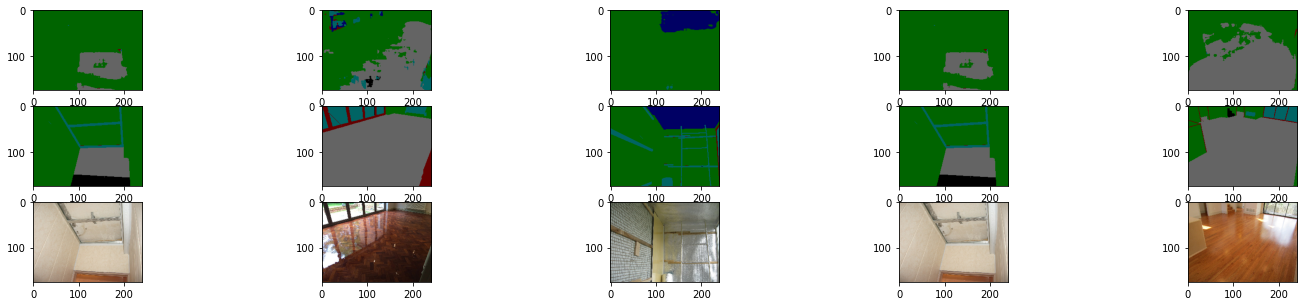

In [0]:

# Визуализация
processImage(model_U_Fpn_32, 5, num_classes)

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(128, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_128 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32_128.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32_128.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 49s 54ms/step - loss: 0.9171 - dice_coef: 0.5838 - val_loss: 3.1714 - val_dice_coef: 0.5688
Epoch 2/50
900/900 [==============================] - 43s 48ms/step - loss: 0.5745 - dice_coef: 0.7143 - val_loss: 1.4286 - val_dice_coef: 0.6742
Epoch 3/50
900/900 [==============================] - 43s 48ms/step - loss: 0.5069 - dice_coef: 0.7456 - val_loss: 0.7523 - val_dice_coef: 0.7702
Epoch 4/50
900/900 [==============================] - 43s 48ms/step - loss: 0.4609 - dice_coef: 0.7653 - val_loss: 0.6963 - val_dice_coef: 0.7408
Epoch 5/50
900/900 [==============================] - 43s 48ms/step - loss: 0.4194 - dice_coef: 0.7848 - val_loss: 0.6360 - val_dice_coef: 0.7533
Epoch 6/50
900/900 [==============================] - 43s 48ms/step - loss: 0.3839 - dice_coef: 0.8025 - val_loss: 0.7911 - val_dice_coef: 0.6968
Epoch 7/50
900/900 [==============================] - 43s 48ms/step - loss: 0.3

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(128, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(128, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.25)(out_2x_x)
out_4x_x = Dropout(0.25)(out_4x_x)
out_8x_x = Dropout(0.25)(out_8x_x)
out_16x_x = Dropout(0.25)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(256, (5, 5), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=60, batch_size=8, validation_data = (xVal, yVal)) #  Обучаем модель

NameError: ignored

# U_net + FPN на 5 выходов - 0.8225

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64
out_16 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_16')(out_16x_x)

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64
out_8 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_8')(out_8x_x)


out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64
out_4 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_4')(out_4x_x)


out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64
out_2 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_2')(out_2x_x)


out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(128, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_5 = Model(input=model.input, output=[out, out_2, out_4, out_8, out_16]) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:127: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32_5.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32_5.fit(xTrain, [yTrain, yTrain, yTrain, yTrain, yTrain], 
                             epochs=50, batch_size=16, 
                             validation_data = (xVal, [yVal, yVal, yVal, yVal, yVal])) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 58s 64ms/step - loss: 4.4469 - out_convF_loss: 0.8219 - out_2_loss: 0.8885 - out_4_loss: 0.8688 - out_8_loss: 0.9013 - out_16_loss: 0.9972 - out_convF_dice_coef: 0.6186 - out_2_dice_coef: 0.5829 - out_4_dice_coef: 0.5935 - out_8_dice_coef: 0.5761 - out_16_dice_coef: 0.5300 - val_loss: 13.8140 - val_out_convF_loss: 5.0879 - val_out_2_loss: 3.0567 - val_out_4_loss: 2.1525 - val_out_8_loss: 1.7686 - val_out_16_loss: 0.9103 - val_out_convF_dice_coef: 0.4537 - val_out_2_dice_coef: 0.5856 - val_out_4_dice_coef: 0.6769 - val_out_8_dice_coef: 0.6421 - val_out_16_dice_coef: 0.6260
Epoch 2/50
900/900 [==============================] - 51s 57ms/step - loss: 3.3916 - out_convF_loss: 0.6009 - out_2_loss: 0.6391 - out_4_loss: 0.6525 - out_8_loss: 0.6993 - out_16_loss: 0.8117 - out_convF_dice_coef: 0.6973 - out_2_dice_coef: 0.6845 - out_4_dice_coef: 0.6808 - out_8_dice_coef: 0.6585 - out_16_dice_coef: 0

# UpSamplind вместо conv2DTranpose - 0.81

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
#out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)
out_8x  = UpSampling2D(size=(2,2))(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
#out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)
out_4x  = UpSampling2D(size=(2,2))(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
#out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)
out_2x  = UpSampling2D(size=(2,2))(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
#out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)
out_x  = UpSampling2D(size=(2,2))(out_x)

# Выходной блок
out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=30, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/30
900/900 [==============================] - 21s 23ms/step - loss: 0.8061 - dice_coef: 0.6181 - val_loss: 8.4237 - val_dice_coef: 0.3036
Epoch 2/30
900/900 [==============================] - 18s 20ms/step - loss: 0.5758 - dice_coef: 0.7079 - val_loss: 4.2072 - val_dice_coef: 0.3209
Epoch 3/30
900/900 [==============================] - 18s 20ms/step - loss: 0.5301 - dice_coef: 0.7259 - val_loss: 2.3905 - val_dice_coef: 0.3424
Epoch 4/30
900/900 [==============================] - 18s 20ms/step - loss: 0.4679 - dice_coef: 0.7593 - val_loss: 0.7137 - val_dice_coef: 0.7611
Epoch 5/30
900/900 [==============================] - 18s 20ms/step - loss: 0.4247 - dice_coef: 0.7775 - val_loss: 0.7596 - val_dice_coef: 0.7062
Epoch 6/30
900/900 [==============================] - 18s 20ms/step - loss: 0.3991 - dice_coef: 0.7927 - val_loss: 1.2042 - val_dice_coef: 0.5789
Epoch 7/30
900/900 [==============================] - 18s 20ms/step - loss: 0.3

# FPN только UpSampling 0.8081

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
#out_16x_x   = Conv2DTranspose(64, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64
out_16x_x  = UpSampling2D(size=(16,16))(out_16x)

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)
#out_8x  = UpSampling2D(size=(2,2))(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
#out_8x_x   = Conv2DTranspose(64, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64
out_8x_x  = UpSampling2D(size=(8,8))(out_8x)

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)
#out_4x  = UpSampling2D(size=(2,2))(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
#out_4x_x   = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64
out_4x_x  = UpSampling2D(size=(4,4))(out_4x)

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)
#out_2x  = UpSampling2D(size=(2,2))(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
#out_2x_x   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64
out_2x_x  = UpSampling2D(size=(2,2))(out_2x)

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)
#out_x  = UpSampling2D(size=(2,2))(out_x)

# Выходной блок
out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(64, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=30, batch_size=8, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/30
900/900 [==============================] - 49s 54ms/step - loss: 0.7788 - dice_coef: 0.6172 - val_loss: 1.4464 - val_dice_coef: 0.4008
Epoch 2/30
900/900 [==============================] - 42s 47ms/step - loss: 0.5790 - dice_coef: 0.7044 - val_loss: 1.0430 - val_dice_coef: 0.5468
Epoch 3/30
900/900 [==============================] - 42s 47ms/step - loss: 0.5335 - dice_coef: 0.7298 - val_loss: 0.8377 - val_dice_coef: 0.6340
Epoch 4/30
900/900 [==============================] - 42s 47ms/step - loss: 0.4695 - dice_coef: 0.7594 - val_loss: 0.6808 - val_dice_coef: 0.7068
Epoch 5/30
900/900 [==============================] - 42s 47ms/step - loss: 0.4462 - dice_coef: 0.7701 - val_loss: 0.7150 - val_dice_coef: 0.7074
Epoch 6/30
900/900 [==============================] - 42s 47ms/step - loss: 0.4147 - dice_coef: 0.7874 - val_loss: 0.8824 - val_dice_coef: 0.6435
Epoch 7/30
900/900 [==============================] - 42s 47ms/step - loss: 0.3

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(512, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(128, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=30, batch_size=8, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/30
900/900 [==============================] - 41s 46ms/step - loss: 0.7909 - dice_coef: 0.6245 - val_loss: 3.4720 - val_dice_coef: 0.2962
Epoch 2/30
900/900 [==============================] - 38s 42ms/step - loss: 0.6232 - dice_coef: 0.6882 - val_loss: 1.0157 - val_dice_coef: 0.5181
Epoch 3/30
900/900 [==============================] - 38s 42ms/step - loss: 0.5643 - dice_coef: 0.7166 - val_loss: 0.9016 - val_dice_coef: 0.6272
Epoch 4/30
900/900 [==============================] - 38s 42ms/step - loss: 0.5289 - dice_coef: 0.7317 - val_loss: 0.7402 - val_dice_coef: 0.6961
Epoch 5/30
900/900 [==============================] - 38s 42ms/step - loss: 0.4892 - dice_coef: 0.7540 - val_loss: 0.9669 - val_dice_coef: 0.6349
Epoch 6/30
900/900 [==============================] - 38s 42ms/step - loss: 0.4514 - dice_coef: 0.7682 - val_loss: 0.6884 - val_dice_coef: 0.7400
Epoch 7/30
900/900 [==============================] - 38s 42ms/step - loss: 0.4

# Метрика - Jaccard Coefficient

In [0]:
# Create a new model
model_U_Fpn = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

# Компилируем модель 
model_U_Fpn.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[jaccard_coef])
model_U_Fpn.summary()



Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 176, 240, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 176, 240, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 88, 120, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  


In [0]:
history = model_U_Fpn.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/10
900/900 [==============================] - 70s 78ms/step - loss: 0.1830 - jaccard_coef: 0.8228 - val_loss: 0.9191 - val_jaccard_coef: 0.5838
Epoch 2/10
900/900 [==============================] - 70s 77ms/step - loss: 0.1724 - jaccard_coef: 0.8316 - val_loss: 0.7603 - val_jaccard_coef: 0.6420
Epoch 3/10
900/900 [==============================] - 70s 77ms/step - loss: 0.1630 - jaccard_coef: 0.8413 - val_loss: 0.8584 - val_jaccard_coef: 0.6327
Epoch 4/10
900/900 [==============================] - 69s 77ms/step - loss: 0.1542 - jaccard_coef: 0.8466 - val_loss: 0.8470 - val_jaccard_coef: 0.6415
Epoch 5/10
900/900 [==============================] - 70s 77ms/step - loss: 0.1556 - jaccard_coef: 0.8470 - val_loss: 0.9037 - val_jaccard_coef: 0.6386
Epoch 6/10
900/900 [==============================] - 69s 77ms/step - loss: 0.1604 - jaccard_coef: 0.8441 - val_loss: 1.2640 - val_jaccard_coef: 0.5457
Epoch 7/10
900/900 [=======================

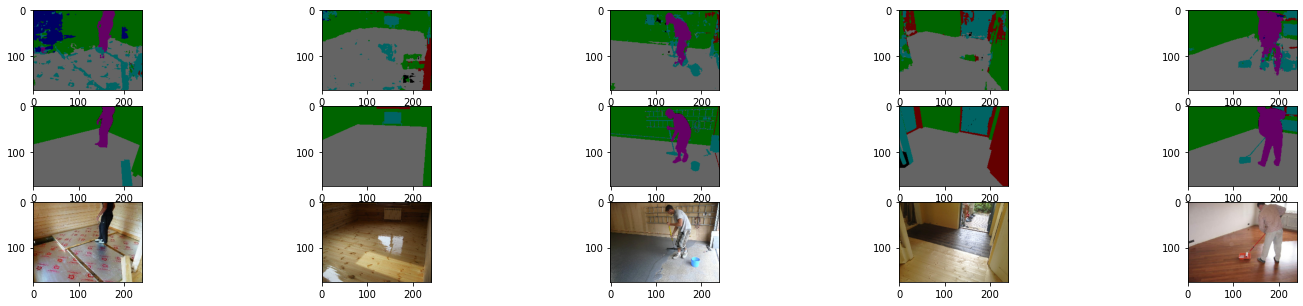

In [0]:
# Распознавание
processImage(model_U_Fpn, 5, num_classes)

# Сегментация самолетов

*Разбор данного раздела:* https://youtu.be/1cJcJY3K-Ow?t=6317

In [0]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height =  320 # Высота уменьшенной картинки 
directory = '/content/drive/My Drive/Базы/Самолеты/' # Указываем путь к обучающей выборке с оригинальными изображения
num_classes = 2 # Количество классов на изображении

## Загрузка изображений

In [0]:
images_airplane = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'Самолеты')): # Проходим по всем файлам в каталоге по указанному пути     
    images_airplane.append(image.load_img(os.path.join(directory + 'Самолеты',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки:  369.7671756744385 c


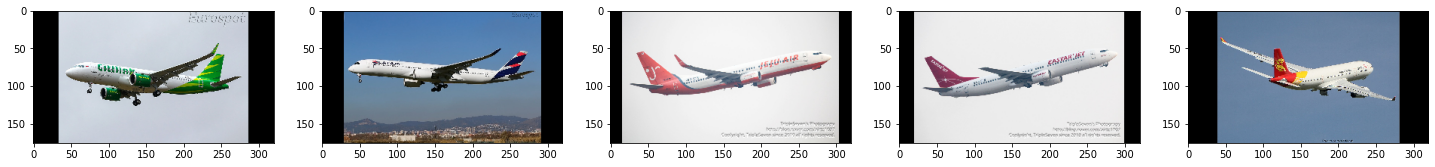

In [0]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(images_airplane) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [0]:
segments_airplane = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'Segment')): # Проходим по всем файлам в каталоге по указанному пути     
    segments_airplane.append(image.load_img(os.path.join(directory + 'Segment',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки:  339.42017364501953 c


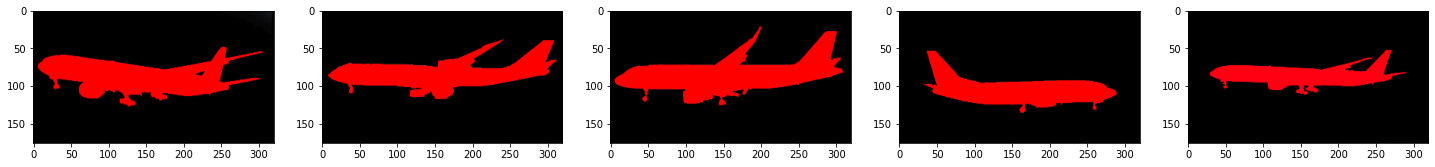

In [0]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(segments_airplane) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Создание выборки

In [0]:
# Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index  

In [0]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # пол
    elif index == 1:
        color = [255, 0, 0]  # потолок
    return color 

In [0]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [0]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [0]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_airplane: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(1000, 176, 320, 3)


In [0]:
cur_time = time.time()
yTrain = yt_prep(segments_airplane, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100
200
300
400
500
600
700
800
900
1000
Время обработки:  753.46 c


In [0]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [0]:
y_train.shape

(900, 176, 320, 2)

## Обучение модели

In [0]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [0]:
#modelAir = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet
# Дообучение (суммарно 35 эпох)
history = modelAir.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_val, y_val), initial_epoch=30) # Обучаем модель на выборке по трем классам

Epoch 31/35
57/57 [==============================] - 75s 1s/step - loss: 0.0320 - dice_coef: 0.9848 - val_loss: 0.0501 - val_dice_coef: 0.9757
Epoch 32/35
57/57 [==============================] - 75s 1s/step - loss: 0.0307 - dice_coef: 0.9852 - val_loss: 0.0559 - val_dice_coef: 0.9737
Epoch 33/35
57/57 [==============================] - 75s 1s/step - loss: 0.0324 - dice_coef: 0.9848 - val_loss: 0.0554 - val_dice_coef: 0.9721
Epoch 34/35
57/57 [==============================] - 75s 1s/step - loss: 0.0306 - dice_coef: 0.9853 - val_loss: 0.0719 - val_dice_coef: 0.9635
Epoch 35/35
57/57 [==============================] - 75s 1s/step - loss: 0.0302 - dice_coef: 0.9860 - val_loss: 0.0818 - val_dice_coef: 0.9570


In [0]:
modelAir.save_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelAir.h5')

## Распознавание

In [0]:
modelAir = unet(2, (img_width, img_height,3))
modelAir.load_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelAir.h5')

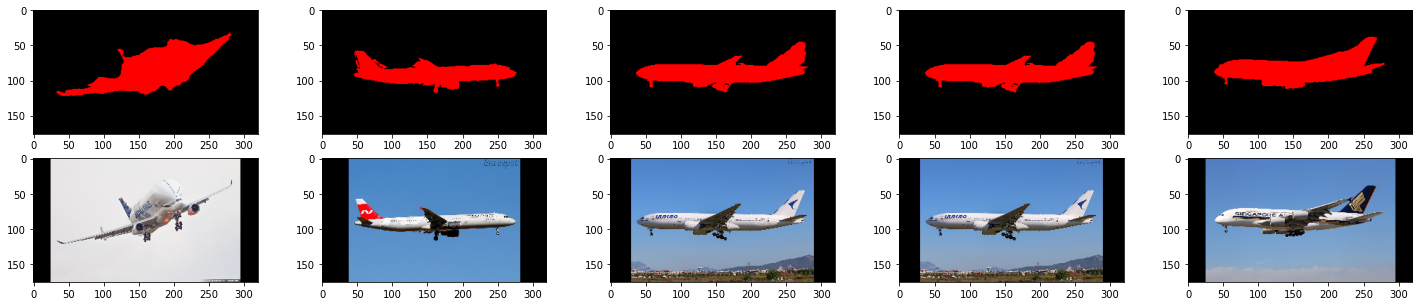

In [0]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
  predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
  pr = predict[0] # Берем нулевой элемент из перидкта
  pr1 = [] # Пустой лист под сегментированную картинку из predicta
  pr = pr.reshape(-1, n_classes) # Решейпим предикт
  for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
    pr1.append(index2color(pr[k])) # Переводим индекс в писксель
  pr1 = np.array(pr1) # Преобразуем в numpy
  pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
  img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
  axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 

### Наложение маски

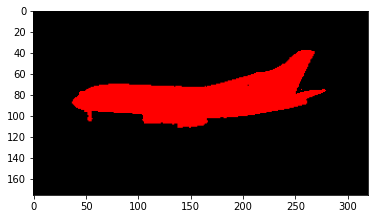

In [0]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)

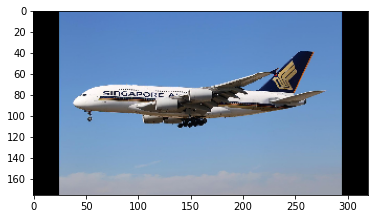

In [0]:
plt.imshow(Image.fromarray(x_val[idx].astype('uint8')))

In [0]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [0, 150, 0, 150]

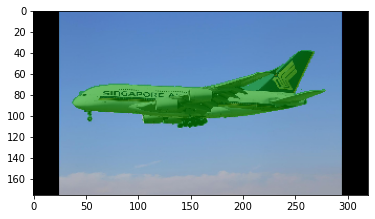

In [0]:
img2 = Image.fromarray(x_val[idx].astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')
img2.paste(img, (0, 0),img)
plt.imshow(img2)

# Метрика дайс как лосс функция - 0.795

In [0]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-6exvpz_s
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-6exvpz_s
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=53b34fac9ef44a51e8229f280ffaa66611e891fdc5ccf7d083b5ce96767edab7
  Stored in directory: /tmp/pip-ephem-wheel-cache-orthyk3c/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(256, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('elu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(256, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('elu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(256, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('elu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(256, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x   = Conv2DTranspose(4, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64

out_16x = Conv2D(128, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('elu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(128, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('elu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(128, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('elu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = Conv2DTranspose(8, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64

out_8x = Conv2D(64, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('elu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(64, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('elu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(64, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('elu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = Conv2DTranspose(16, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64

out_4x = Conv2D(32, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('elu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(32, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('elu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x   = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64

out_x = Conv2D(16, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('elu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(16, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('elu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(16, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('elu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (1, 1), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [0]:
# Create a new model
model_U_Fpn_32 = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

model_U_Fpn_32.compile(optimizer=Adam(), loss=sm.losses.bce_jaccard_loss, metrics=[dice_coef])
history = model_U_Fpn_32.fit(xTrain, yTrain, epochs=50, batch_size=8, validation_data = (xVal, yVal)) #  Обучаем модель

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  


Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 13s 14ms/step - loss: 1.1475 - dice_coef: 0.4017 - val_loss: 1.1830 - val_dice_coef: 0.7084
Epoch 2/50
900/900 [==============================] - 9s 10ms/step - loss: 0.8858 - dice_coef: 0.6638 - val_loss: 0.9387 - val_dice_coef: 0.7423
Epoch 3/50
900/900 [==============================] - 9s 10ms/step - loss: 0.8175 - dice_coef: 0.7241 - val_loss: 0.8677 - val_dice_coef: 0.7482
Epoch 4/50
900/900 [==============================] - 9s 10ms/step - loss: 0.7770 - dice_coef: 0.7537 - val_loss: 0.8506 - val_dice_coef: 0.7520
Epoch 5/50
900/900 [==============================] - 9s 10ms/step - loss: 0.7407 - dice_coef: 0.7774 - val_loss: 0.9085 - val_dice_coef: 0.7353
Epoch 6/50
900/900 [==============================] - 9s 10ms/step - loss: 0.7003 - dice_coef: 0.7981 - val_loss: 0.8314 - val_dice_coef: 0.7846
Epoch 7/50
900/900 [==============================] - 9s 10ms/step - loss: 0.6697 - 

# Взвешенная одновыходовая сеть

In [0]:
#dict_values([1.0, 1.0, 1.0, 1.4928074923988774, 1.0, 2.221416368388939, 3.9383017342428044])
# [1.00, 1.00, 1.00, 1.49, 1.00, 2.22, 3.94]

#[1.4987106681577635, 1.9300334371899897, 1.0, 3.227408547786984, 2.049443452575469, 3.9560174237770456, 5.6729027896309105]
#[1.498, 1.930, 1.0, 3.227, 2.049, 3.956, 5.672]

In [0]:
def weighted_categorical_crossentropy(weights):   
    def wcce(y_true, y_pred):
        Kweights = K.constant(weights)
        # if not K.is_tensor(y_pred): 
        #   y_pred = K.constant(y_pred)
        #   y_true = K.cast(y_true, y_pred.dtype)
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
    return wcce

In [0]:
# Create a new model
model_U_Fpn_32_w = Model(input=model.input, output=out) # Создаем модель с входом 'img_input' и выходом 'out'

#weights = [1.00, 1.00, 1.00, 1.49, 1.00, 2.22, 3.94]
weights = [1.498, 1.930, 1.0, 3.227, 2.049, 3.956, 5.672]
loss = weighted_categorical_crossentropy(weights)

model_U_Fpn_32_w.compile(optimizer=Adam(), loss=loss, metrics=[dice_coef])
history = model_U_Fpn_32_w.fit(xTrain, yTrain, epochs=50, batch_size=8, validation_data = (xVal, yVal)) #  Обучаем модель

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  


Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 11s 12ms/step - loss: 2.2775 - dice_coef: 0.2735 - val_loss: 2.0698 - val_dice_coef: 0.5463
Epoch 2/50
900/900 [==============================] - 9s 10ms/step - loss: 1.4861 - dice_coef: 0.4880 - val_loss: 1.5629 - val_dice_coef: 0.5857
Epoch 3/50
900/900 [==============================] - 9s 10ms/step - loss: 1.2359 - dice_coef: 0.5905 - val_loss: 1.4489 - val_dice_coef: 0.6325
Epoch 4/50
900/900 [==============================] - 9s 10ms/step - loss: 1.1048 - dice_coef: 0.6421 - val_loss: 1.5132 - val_dice_coef: 0.6426
Epoch 5/50
900/900 [==============================] - 9s 10ms/step - loss: 1.0011 - dice_coef: 0.6800 - val_loss: 1.4151 - val_dice_coef: 0.6465
Epoch 6/50
900/900 [==============================] - 9s 10ms/step - loss: 0.9428 - dice_coef: 0.6996 - val_loss: 1.4853 - val_dice_coef: 0.6291
Epoch 7/50
900/900 [==============================] - 9s 10ms/step - loss: 0.9048 - 

KeyboardInterrupt: ignored

# U_net + UP Sampling - FPN на 5 выходов = 0,8325

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(128, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x  = UpSampling2D(size=(16,16))(out_16x) # 176*240*64
#out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64
out_16 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_16')(out_16x_x)

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = UpSampling2D(size=(8,8))(out_8x) # 176*240*64
#out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64
out_8 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_8')(out_8x_x)


out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = UpSampling2D(size=(4,4))(out_4x) # 176*240*64
#out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64
out_4 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_4')(out_4x_x)


out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x  = UpSampling2D(size=(2,2))(out_2x) # 176*240*64
#out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64
out_2 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_2')(out_2x_x)


out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(128, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_5 = Model(input=model.input, output=[out, out_2, out_4, out_8, out_16]) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32_5.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32j.summary()
history = model_U_Fpn_32_5.fit(xTrain, [yTrain, yTrain, yTrain, yTrain, yTrain], 
                             epochs=50, batch_size=8, 
                             validation_data = (xVal, [yVal, yVal, yVal, yVal, yVal])) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 46s 51ms/step - loss: 4.3020 - out_convF_loss: 0.8576 - out_2_loss: 1.0268 - out_4_loss: 0.8178 - out_8_loss: 0.7276 - out_16_loss: 0.8734 - out_convF_dice_coef: 0.5989 - out_2_dice_coef: 0.4993 - out_4_dice_coef: 0.6072 - out_8_dice_coef: 0.6593 - out_16_dice_coef: 0.6045 - val_loss: 4.8672 - val_out_convF_loss: 0.8703 - val_out_2_loss: 1.2504 - val_out_4_loss: 1.0748 - val_out_8_loss: 0.7028 - val_out_16_loss: 0.8332 - val_out_convF_dice_coef: 0.6964 - val_out_2_dice_coef: 0.3622 - val_out_4_dice_coef: 0.5608 - val_out_8_dice_coef: 0.7189 - val_out_16_dice_coef: 0.6891
Epoch 2/50
900/900 [==============================] - 41s 45ms/step - loss: 3.1743 - out_convF_loss: 0.5420 - out_2_loss: 0.7783 - out_4_loss: 0.6350 - out_8_loss: 0.5508 - out_16_loss: 0.6636 - out_convF_dice_coef: 0.7342 - out_2_dice_coef: 0.6183 - out_4_dice_coef: 0.6924 - out_8_dice_coef: 0.7297 - out_16_dice_coef: 0.

# U_net + UP Sampling - FPN на 6 выходов = 0.832

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(128, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x  = UpSampling2D(size=(16,16))(out_16x) # 176*240*64
#out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64
out_16 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_16')(out_16x_x)

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = UpSampling2D(size=(8,8))(out_8x) # 176*240*64
#out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64
out_8 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_8')(out_8x_x)


out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = UpSampling2D(size=(4,4))(out_4x) # 176*240*64
#out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64
out_4 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_4')(out_4x_x)


out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x  = UpSampling2D(size=(2,2))(out_2x) # 176*240*64
#out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64
out_2 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_2')(out_2x_x)

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)
out_1 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(128, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_6 = Model(input=model.input, output=[out, out_1, out_2, out_4, out_8, out_16]) # Создаем модель с входом 'img_input' и выходом 'out'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [0]:
# weights = [1.00, 1.00, 1.00, 1.49, 1.00, 2.22, 3.94]
# #weights = [1.498, 1.930, 1.0, 3.227, 2.049, 3.956, 5.672]
# loss = weighted_categorical_crossentropy(weights)

# model_U_Fpn_32_6_w.compile(optimizer=Adam(), loss=loss, metrics=[dice_coef])
# history = model_U_Fpn_32_6_w.fit(xTrain, [yTrain, yTrain, yTrain, yTrain, yTrain, yTrain],
#                                epochs=100, batch_size=8,
#                                validation_data = (xVal, [yVal, yVal, yVal, yVal, yVal, yVal])) #  Обучаем модель

In [0]:
# Таже сеть но с метрикой Дайс
# Компилируем модель 
model_U_Fpn_32_6.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
#model_U_Fpn_32_6.summary()
history = model_U_Fpn_32_6.fit(xTrain, [yTrain, yTrain, yTrain, yTrain, yTrain, yTrain], 
                             epochs=50, batch_size=8, 
                             validation_data = (xVal, [yVal, yVal, yVal, yVal, yVal, yVal])) #  Обучаем модель

Train on 900 samples, validate on 50 samples
Epoch 1/50
900/900 [==============================] - 46s 51ms/step - loss: 5.4671 - out_convF_loss: 0.8716 - out_1_loss: 1.2026 - out_2_loss: 1.0291 - out_4_loss: 0.8144 - out_8_loss: 0.7068 - out_16_loss: 0.8426 - out_convF_dice_coef: 0.5942 - out_1_dice_coef: 0.4099 - out_2_dice_coef: 0.5022 - out_4_dice_coef: 0.6089 - out_8_dice_coef: 0.6650 - out_16_dice_coef: 0.6067 - val_loss: 6.0835 - val_out_convF_loss: 0.7577 - val_out_1_loss: 1.4314 - val_out_2_loss: 1.1929 - val_out_4_loss: 1.1056 - val_out_8_loss: 0.6541 - val_out_16_loss: 0.8564 - val_out_convF_dice_coef: 0.7203 - val_out_1_dice_coef: 0.3107 - val_out_2_dice_coef: 0.4422 - val_out_4_dice_coef: 0.5500 - val_out_8_dice_coef: 0.7083 - val_out_16_dice_coef: 0.6330
Epoch 2/50
900/900 [==============================] - 42s 47ms/step - loss: 4.3801 - out_convF_loss: 0.5931 - out_1_loss: 0.9352 - out_2_loss: 0.8247 - out_4_loss: 0.6932 - out_8_loss: 0.6222 - out_16_loss: 0.7080 - out_c

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(128, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x  = UpSampling2D(size=(16,16))(out_16x) # 176*240*64
#out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64
out_16 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_16')(out_16x_x)

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = UpSampling2D(size=(8,8))(out_8x) # 176*240*64
#out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64
out_8 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_8')(out_8x_x)


out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = UpSampling2D(size=(4,4))(out_4x) # 176*240*64
#out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64
out_4 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_4')(out_4x_x)


out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x  = UpSampling2D(size=(2,2))(out_2x) # 176*240*64
#out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64
out_2 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_2')(out_2x_x)

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)
out_1 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(128, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_6_w = Model(input=model.input, output=[out, out_1, out_2, out_4, out_8, out_16]) # Создаем модель

#weights = [1.00, 1.00, 1.00, 1.49, 1.00, 2.22, 3.94]
weights = [1.498, 1.930, 1.0, 3.227, 2.049, 3.956, 5.672]
loss = weighted_categorical_crossentropy(weights)

model_U_Fpn_32_6_w.compile(optimizer=Adam(), loss=loss, metrics=[dice_coef])
history = model_U_Fpn_32_6_w.fit(xTrain, [yTrain, yTrain, yTrain, yTrain, yTrain, yTrain],
                               epochs=100, batch_size=8,
                               validation_data = (xVal, [yVal, yVal, yVal, yVal, yVal, yVal])) #  Обучаем модель

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 900 samples, validate on 50 samples
Epoch 1/100
900/900 [==============================] - 45s 50ms/step - loss: 9.7868 - out_convF_loss: 1.5538 - out_1_loss: 2.0415 - out_2_loss: 1.8022 - out_4_loss: 1.4946 - out_8_loss: 1.3288 - out_16_loss: 1.5569 - out_convF_dice_coef: 0.5441 - out_1_dice_coef: 0.3618 - out_2_dice_coef: 0.4483 - out_4_dice_coef: 0.5510 - out_8_dice_coef: 0.6102 - out_16_dice_coef: 0.5479 - val_loss: 12.0884 - val_out_convF_loss: 1.6576 - val_out_1_loss: 2.6399 - val_out_2_loss: 2.1805 - val_out_4_loss: 2.1157 - val_out_8_loss: 1.6172 - val_out_16_loss: 1.5652 - val_out_convF_dice_coef: 0.6094 - val_out_1_dice_coef: 0.2530 - val_out_2_dice_coef: 0.3443 - val_out_4_dice_coef: 0.4360 - val_out_8_dice_coef: 0.5916 - val_out_16_dice_coef: 0.6075
Epoch 2/100
900/900 [==============================] - 43s 47ms/step - loss: 7.6367 - out_convF_loss: 1.0262 - out_1_loss: 1.6245 - out_2_loss: 1.4636 - out_4_loss: 1.2307 - out_8_loss: 1.0529 - out_16_loss: 1.2328 - ou

KeyboardInterrupt: ignored

In [0]:
# U-net + FPN c с глубиной свертки до 32 и конекшнами с 16

from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from keras.applications import VGG16
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers:
        layer.trainable = False
#model.summary()

# Получаем выходу со слоев энкодера
inp_x = model.layers[-17]
out_mp_x = inp_x.output   # Выход 176*240*64
#inp_x.summary()

mp_2x = model.layers[-16]
out_mp_2x = mp_2x.output  # Выход  88*120*64
#mp_2x.summary()

mp_4x = model.layers[-13]
out_mp_4x = mp_4x.output  # Выход  44*60*128
#mp_4x.summary()

mp_8x = model.layers[-9]
out_mp_8x = mp_8x.output  # Выход  22*30*256
#mp_8x.summary()

mp_16x = model.layers[-5]
out_mp_16x = mp_16x.output# Выход  11*15*512
#mp_16x.summary()

mp_32x = model.layers[-1]
out_mp_32x = mp_32x.output# Выход  5*7*512
#mp_32x.summary()

#out_xxx = concatenate([out_mp_x, out_mp_2x, out_mp_4x, out_mp_8x, out_mp_16x, out_mp_32x])

# Сжатие в 32 раз - 5*7*512
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv13_32x')(out_mp_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv12_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_32x = Conv2D(512, (3, 3), padding='same', name='out_conv11_32x')(out_32x)
out_32x = BatchNormalization()(out_32x) # Добавляем слой BatchNormalization
out_32x = Activation('relu')(out_32x) # Добавляем слой Activation
out_16x  = Conv2DTranspose(128, (3, 3), strides=(2, 2), name='conv2Dtr_16x_5')(out_32x)

out_16x_con = concatenate([out_16x, out_mp_16x]) # 11*15*512
out_16x_x  = UpSampling2D(size=(16,16))(out_16x) # 176*240*64
#out_16x_x   = Conv2DTranspose(128, (16, 16), strides=(16, 16), padding='same', name='conv2Dtr_16x_x')(out_16x) # 176*240*64
out_16 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_16')(out_16x_x)

out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv10_16x')(out_16x_con)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv9_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_16x = Conv2D(512, (3, 3), padding='same', name='out_conv8_16x')(out_16x)
out_16x = BatchNormalization()(out_16x) # Добавляем слой BatchNormalization
out_16x = Activation('relu')(out_16x) # Добавляем слой Activation
out_8x  = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_4')(out_16x)

out_8x_con = concatenate([out_8x, out_mp_8x]) # 22*30*256
out_8x_x   = UpSampling2D(size=(8,8))(out_8x) # 176*240*64
#out_8x_x   = Conv2DTranspose(128, (8, 8), strides=(8, 8), padding='same', name='conv2Dtr_8x_x')(out_8x) # 176*240*64
out_8 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_8')(out_8x_x)


out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv7_16x')(out_8x_con)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv6_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_8x = Conv2D(256, (3, 3), padding='same', name='out_conv5_16x')(out_8x)
out_8x = BatchNormalization()(out_8x) # Добавляем слой BatchNormalization
out_8x = Activation('relu')(out_8x) # Добавляем слой Activation
out_4x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_3')(out_8x)

out_4x_con = concatenate([out_4x, out_mp_4x]) # 44*60*128
out_4x_x   = UpSampling2D(size=(4,4))(out_4x) # 176*240*64
#out_4x_x   = Conv2DTranspose(128, (4, 4), strides=(4, 4), padding='same', name='conv2Dtr_4x_x')(out_4x) # 176*240*64
out_4 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_4')(out_4x_x)


out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv4_16x')(out_4x_con)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_4x = Conv2D(128, (3, 3), padding='same', name='out_conv3_16x')(out_4x)
out_4x = BatchNormalization()(out_4x) # Добавляем слой BatchNormalization
out_4x = Activation('relu')(out_4x)   # Добавляем слой Activation
out_2x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_2')(out_4x)

out_2x_con = concatenate([out_2x, out_mp_2x]) # 88*120*64
out_2x_x  = UpSampling2D(size=(2,2))(out_2x) # 176*240*64
#out_2x_x   = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_2x_x')(out_2x) # 176*240*64
out_2 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_2')(out_2x_x)

out_x = Conv2D(64, (3, 3), padding='same', name='out_conv2_16x')(out_2x_con)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2D(64, (3, 3), padding='same', name='out_conv1_16x')(out_x)
out_x = BatchNormalization()(out_x) # Добавляем слой BatchNormalization
out_x = Activation('relu')(out_x)   # Добавляем слой Activation
out_x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='conv2Dtr_16x_1')(out_x)
out_1 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_1')(out_x)

# Выходной блок
#out_x = Dropout(0.5)(out_x)
out_2x_x = Dropout(0.5)(out_2x_x)
out_4x_x = Dropout(0.5)(out_4x_x)
out_8x_x = Dropout(0.5)(out_8x_x)
out_16x_x = Dropout(0.5)(out_16x_x)

out_x_con = concatenate([out_mp_x, out_x, out_2x_x, out_4x_x, out_8x_x, out_16x_x])  # 176*240*64

out = Conv2D(128, (3, 3), padding='same', name='out_conv1')(out_x_con) # Добавляем слой Conv2D с 64 нейронами
out = BatchNormalization()(out) # Добавляем слой BatchNormalization
out = Activation('relu')(out)   # Добавляем слой Activation

out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='out_convF')(out)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

# Create a new model
model_U_Fpn_32_6_w = Model(input=model.input, output=[out, out_1, out_2, out_4, out_8, out_16]) # Создаем модель

#weights = [1.00, 1.00, 1.00, 1.49, 1.00, 2.22, 3.94]
weights = [3.956, 3.227, 5.672, 1.930, 2.049, 1.498, 1.0]
#weights = [1.498, 1.930, 1.0, 3.227, 2.049, 3.956, 5.672]
loss = weighted_categorical_crossentropy(weights)

model_U_Fpn_32_6_w.compile(optimizer=Adam(), loss=loss, metrics=[dice_coef])
history = model_U_Fpn_32_6_w.fit(xTrain, [yTrain, yTrain, yTrain, yTrain, yTrain, yTrain],
                               epochs=100, batch_size=8,
                               validation_data = (xVal, [yVal, yVal, yVal, yVal, yVal, yVal])) #  Обучаем модель

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 900 samples, validate on 50 samples
Epoch 1/100
900/900 [==============================] - 45s 50ms/step - loss: 18.8110 - out_convF_loss: 2.8688 - out_1_loss: 4.1701 - out_2_loss: 3.5355 - out_4_loss: 2.8371 - out_8_loss: 2.4609 - out_16_loss: 2.9265 - out_convF_dice_coef: 0.6252 - out_1_dice_coef: 0.4546 - out_2_dice_coef: 0.5324 - out_4_dice_coef: 0.6243 - out_8_dice_coef: 0.6748 - out_16_dice_coef: 0.6326 - val_loss: 19.1102 - val_out_convF_loss: 2.5421 - val_out_1_loss: 4.6057 - val_out_2_loss: 3.6809 - val_out_4_loss: 3.0752 - val_out_8_loss: 2.1991 - val_out_16_loss: 2.6675 - val_out_convF_dice_coef: 0.7399 - val_out_1_dice_coef: 0.3689 - val_out_2_dice_coef: 0.5005 - val_out_4_dice_coef: 0.6297 - val_out_8_dice_coef: 0.7575 - val_out_16_dice_coef: 0.7054
Epoch 2/100
900/900 [==============================] - 43s 47ms/step - loss: 13.2441 - out_convF_loss: 1.7797 - out_1_loss: 2.8025 - out_2_loss: 2.4960 - out_4_loss: 2.1130 - out_8_loss: 1.8456 - out_16_loss: 2.2145 - 